$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

*Ben Newell*

## Overview
This project explores neural networks. It implements methods that use the neural network code supplied in nn2.tar and explores different strategies for regression and classification problems. Plots of expected values and residuals are used to test the neural network approach to interpreting the data. 

## Method Definitions
This section contains the implementations of the required code and other methods used throughout the notebook. They are used to create, interact with and interpret neural networks with data sets. 

Here are all of this notebooks required imports. The first three are from the supplied tar. They effectively make up the supplied neural network. `time` is used for timing the individual trials. `numpy` is used for some of its utility functions. `matplotlib.pyplot` is used for plotting data about the networks. `pandas` is used for its ease of reading in csvs. 

In [1]:
import neuralnetworks as nn
import scaledconjugategradient as scg
import mlutils as ml
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

`trainNNs` is meant to train and evaluate the effectiveness of neural networks with a selection of different hidden layer structures. As input it takes the input matrix `X`, the target matrix `T`, or `Y` as I have written it. These represent the data collected from the experiment where `X` contains the predictor variables and `T` contains the response. Also passed as input is `trainFraction` which determines the amount of the data to set aside for testing the neural network after training. This allows us to test how the network performs on unseen data. `hiddenLayerStructures` is a list of lists of ints. Each list represents a hidden layer structure that `trainNNs` should evaluate. [10,2,10] for example would create a neural network of three hidden layers with 10, 2 and 10 hidden units respectively. `numberRepetitions` tells `trainNNs` how many times to run each trial. Training neural networks is a stochastic process, so we run multiple trails in order to find a mean and have a better idea about the average performance of a model. `numberIterations`, not to be confused with `numberRepetitions`, tells `trainNNs` how long to train the neural networks. Each network is trained for the same amount of iterations, although it could be interesting to see how perfromance varies with different numbers of iterations. `classify` simply telss `trainNNs` whether to classify or regress on the given data. If set to `True`, we use a `NeuralNetworkClassifier` instead of `NeuralNetwork`. Classification works better when the response is discrete categories, like determining the species of a frog based on its call. Regression works better when response is more continuous, like finding the MPG of a car based on factors like its weight, age, and mileage. I also added `residuals`, which if true returns the residuals for each of the models in addition to the RMSE. 

`trainNNs` returns a list of performances of each of the neural networks. They are evaluated based on root mean squared error (RMSE), which determines how much error is in the actual response compared to the predicted response. RMSE is calculated for the training data set and the test data set in order to see how well the network does with new data as well as the training data.

In [2]:
def trainNNs(X, Y, trainFraction, hiddenLayerStructures, numberRepetitions,
             numberIterations, classify = False, residuals = False):
    #In statistics and in the neural net code, the "target" matrix is Y
    #I'm more used to this.
    results = []
    #Evaluate each hidden layer structure given
    for structure in hiddenLayerStructures:
        #Start timing here. It will track the time over n numberRepititions.
        start = time.time()
        #These lists keep track of the RMSE for training and test datas.
        trainedList = []
        testedList = []
        #repeat each trail for numberRepititions. 
        #This helps to find an average performance. 
        for _ in range(numberRepetitions):
            #These are the different partitions to run the train and test on.
            Xtrain,Ytrain,Xtest,Ytest = ml.partition(X, Y, 
                                        (trainFraction, 1 - trainFraction), False)
            #create nn with the right structure.
            #initiallizes ni->columns of X
            #             no->columns of Y
            #             nhs->our given structure in hidden layers
            if not classify:
                nnet = nn.NeuralNetwork(X.shape[1], structure, Y.shape[1])
            #creates nn with classifying structure.
            #initiallizes ni->columns of X
            #             no->classes of Y, given by number of unique values
            #             nhs->our given structure in hidden layers
            else:
                nnet = nn.NeuralNetworkClassifier(X.shape[1],structure, len(np.unique(Y)))
            #Train for number of iterations.
            nnet.train(Xtrain, Ytrain, numberIterations)
            #collect the trained outputs with training data and test data
            predictedYTrained = nnet.use(Xtrain)
            predictedYTested = nnet.use(Xtest)
            #calculate the mean standard error for these dudes.
            #this is not an estimate of sigma like in statistics. 
            #for that you need to adjust for degrees of freedom. 
            #however, it still provides a good estimate of error in the residuals
            if not classify:
                rmseTrained = np.sqrt(np.mean((Ytrain - predictedYTrained) ** 2))
                rmseTested = np.sqrt(np.mean((Ytest - predictedYTested) ** 2))
            #instead of finding RMSE, return percent of misclassified data.
            else:
                rmseTrained =(1 - sum(Ytrain.ravel()==predictedYTrained.ravel())/ float(len(Ytrain))) * 100
                rmseTested =(1 - sum(Ytest.ravel()==predictedYTested.ravel())/ float(len(Ytest))) * 100
            
            trainedList.append(rmseTrained)
            testedList.append(rmseTested)
        #stop the timing here. We could average the time,
        #but I found the whole time more helpful so I could tell whether to re run the data.
        end = time.time()
        results.append([structure, trainedList, testedList, end - start])
        #Here I return the training and test residuals. 
        #I didn't end up really using it though.
        if residuals:
            results.append([Ytrain - predictedYTrained, Ytest - predictedYTested])            
    return results

Although not required, I've implemented a regular linear regression method here. It finds the Ordinary Least Squares estimator of the linear model. I return the RMSE to compare it to the neural networks created throughout the project, and the matrix of betas that can be used to use the model. If the given data has a linear trend and is roughly normal, then this estimator should work very well and is much easier to interpret and evaluate than a complex neural network. We'll see how it does!

In [3]:
def linearRegression(X,Y):
    newX = np.c_[np.ones(len(X)), X] #Adds a column of ones to the beginning for intercept.
    #This finds the OLS estimator for the model
    #beta = (XtX)-1XtY. Thanks cooley!
    betas = np.linalg.inv((np.transpose(newX) @ newX)) @ np.transpose(newX) @ Y
    # our prediction will the be Xo @ beta.
    predictedYs = newX @ betas
    rmse = np.sqrt(np.mean((predictedYs - Y) ** 2))
    #not sdhat     |msres~~~~~~~~~~~~~~~~~~~~~~~~~| <- actually not, should be adjusted for df.
    return rmse, betas

`summarize` cleans up the output of `results` by averaging together the RMSEs of each trial. This helps to give us an idea of the average perfomance of each hidden layer structure. 

In [4]:
def summarize(results):
    summarized = list(range(len(results)))
    for t in range(len(results)):
        summarized[t] = [results[t][0], np.mean(results[t][1]), np.mean(results[t][2]), results[t][3]]
    return summarized

`bestNetwork` Returns the best network from summarize. Our defintion of best is the network with the lowest RMSE or % incorrectly classified on the _testing_ data. A very complex network can achieve very good performance on training data, but we are most interested in its perfomance on new data, so we use the test results. 

In [5]:
def bestNetwork(summary):
    lowestError = float('inf')
    lowestNetwork = summary[0]
    for s in summary:
        if s[2] < lowestError:
            lowestError = s[2]
            lowestNetwork = s
        
    return lowestNetwork
#NOT NEEDED
#I initially had returned % correctly classified, not incorrectly.
#so I needed a different definition of best. But I fixed that so this is unneeded.
def bestNetworkClassification(summary):
    highestPercent = 0;
    highestNetwork = summary[0]
    for s in summary:
        if s[2] > highestPercent:
            highestPercent = s[2]
            highestNetwork = s
    return highestNetwork

This is a helper function that mimmicks the behavior of `abline` from the R programming language. I found it [here](https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib). It simply draws a line based off of the given slope and intercept. 

In [6]:
def abline(slope, intercept):
    #borrowed from: 
    #https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

## Examples
This section verifies the behavior of the methods implemented above.

In [7]:
%matplotlib inline

Creates a linear model and adds random errors to the line.

In [8]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

Here we partition the data created above into testing and training datasets. 

In [9]:
Xtrain,Train, Xtest,Ttest =ml.partition(X, T, (0.7, 0.3), False)

In [10]:
len(X), len(Xtest)

(10, 3)

Looks like a pretty linear trend!

Text(0,0.5,'Y')

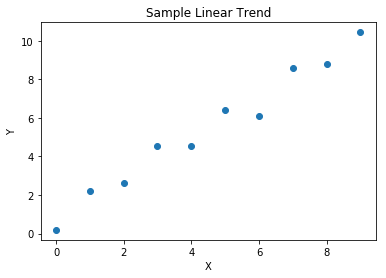

In [11]:
plt.plot(X, T, 'o')
plt.title("Sample Linear Trend")
plt.xlabel("X")
plt.ylabel("Y")

100 iterations should be more than enough to train on this data. 

Text(0.5,0,'Iteration')

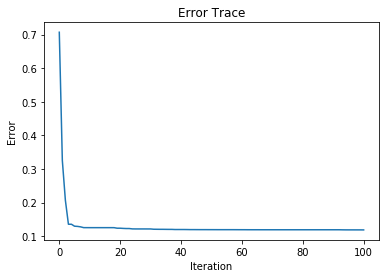

In [12]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
plt.plot(nnet.getErrorTrace())
plt.title("Error Trace")
plt.ylabel("Error")
plt.xlabel("Iteration")

Text(0.5,0,'Iteration')

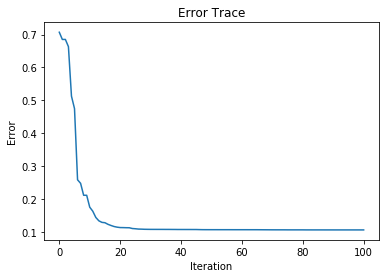

In [13]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
plt.plot(nnet.getErrorTrace())
plt.title("Error Trace")
plt.ylabel("Error")
plt.xlabel("Iteration")

Quick trial of `trainNNs` to see if it runs and finishes correctly.

In [14]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.3758506332523266,
   0.4029620400029696,
   0.46403568122789557,
   0.4098854357564006,
   0.3852611270288373],
  [0.8095147246393304,
   1.4938824295516924,
   0.761438655177319,
   0.9304644488769143,
   0.7006092052315721],
  0.08649086952209473],
 [10,
  [0.3631765090219459,
   0.45958025606299596,
   0.37205775399384433,
   0.3098341365429024,
   0.39897330240805484],
  [0.9306182284357817,
   0.6814055933706099,
   1.216678872568399,
   1.1058165810224143,
   1.2623993739407156],
  0.09278249740600586],
 [[10, 10],
  [0.35712712782999223,
   0.38319162980348553,
   0.3695451266688306,
   0.3036216323893541,
   0.40903740924699156],
  [0.9918174084615696,
   0.8600600538772205,
   0.7614059887434228,
   2.1198439477234516,
   1.030890437233765],
  0.12815189361572266]]

Test with more complicated structures.

In [15]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [16]:
summarize(results)

[[0, 0.5020155716258257, 0.5917996961817076, 0.018899917602539062],
 [1, 0.47871200658862206, 0.7651565879164827, 0.7334535121917725],
 [2, 0.4379129616217458, 0.9741089178265351, 0.8041777610778809],
 [10, 0.37394665693219464, 1.1759059003852188, 0.8839695453643799],
 [[10, 10], 0.3917234985821216, 1.1997297138560676, 1.2382774353027344],
 [[5, 5, 5, 5], 0.41039923088582425, 0.9806099549374229, 1.7643299102783203],
 [[2, 2, 2, 2, 2], 0.47687909921565613, 0.8135157545661325, 1.781968355178833]]

In [17]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.5020155716258257, 0.5917996961817076, 0.018899917602539062]
Hidden Layers 0 Average RMSE Training 0.50 Testing 0.59 Took 0.02 seconds


This simple trend is actually best represented by a neural network without any hidden units. This isn't really surprising because it is trying to learn a line, but we can also represent this pattern with a regular linear regression. 

In [18]:
model = linearRegression(X, T)

Here we print out the model, which takes the form of RMSE, array of betas (Weights)

In [19]:
model

(0.5079800592950255, array([[0.67469139],
        [1.05815887]]))

Linear regression plot of model versus line. Looks like `linearRegression` correctly builds a model. It won't be as easy to print it out with multiple dimensional models, but this gives a quick verification of the implementation.

Text(0.5,0,'X')

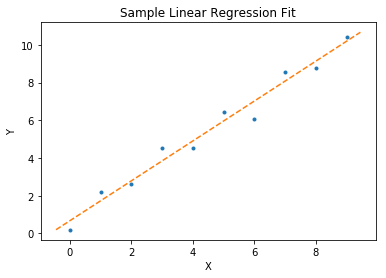

In [20]:
plt.plot(X, T, ".")
abline(model[1][1], model[1][0])
plt.title("Sample Linear Regression Fit")
plt.ylabel("Y")
plt.xlabel("X")

# Running Regression on the Appliance Energy Dataset

This section reads in the csv and formats it correctly for the methods implemented above. Then, it runs the experiment and interprets the results.


## Reading in the Data
Here is where the data from `energydata_complete.csv` is read in. This uses pandas, which has a function to read a csv into a pandas dataframe really easily! It handles the double quotes just fine as well, correctly reading the values as floats. In order to drop columns from a pandas dataframe, the drop function with a list of names to remove is used. This removes the date, rv1 and rv2 columns from the dataframe.

In [21]:
csv = pd.read_csv("energydata_complete.csv")
#drop unneeded columns
csv = csv.drop(['date', 'rv1', 'rv2'], axis = 1)

Here are the columns loaded in from the csv. I do not read this into its own variable names. We see that data, rv1, and rv2 have been correctly left out. 

In [22]:
#names
csv.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'],
      dtype='object')

The dataframe still needs to be converted to a numpy array however. Luckily, this is easy to do. Looks like it has the correct dimensionality of 19735x26.

In [23]:
data = csv.values #.values is a numpy array! 
data.shape

(19735, 26)

Here are a few sample rows. The first two, appliances and lights, are the targets of the model. These values tend to be discrete as well, later on we see that classification could be explored as a solution.

In [24]:
data[:2,:]

array([[ 60.        ,  30.        ,  19.89      ,  47.59666667,
         19.2       ,  44.79      ,  19.79      ,  44.73      ,
         19.        ,  45.56666667,  17.16666667,  55.2       ,
          7.02666667,  84.25666667,  17.2       ,  41.62666667,
         18.2       ,  48.9       ,  17.03333333,  45.53      ,
          6.6       , 733.5       ,  92.        ,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      ,  46.69333333,
         19.2       ,  44.7225    ,  19.79      ,  44.79      ,
         19.        ,  45.9925    ,  17.16666667,  55.2       ,
          6.83333333,  84.06333333,  17.2       ,  41.56      ,
         18.2       ,  48.86333333,  17.06666667,  45.56      ,
          6.48333333, 733.6       ,  92.        ,   6.66666667,
         59.16666667,   5.2       ]])

Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So we split off the first two columns into the target matrix, and the remaining into the X matrix. 

In [25]:
Tenergy = data[:, :2]
Xenergy = data[:, 2:]

Looks like we got the correct dimensionality, 19735x24 and 19735x2 for `Xenergy` and `Tenergy`. 

In [26]:
Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

This quick trial run is from the supplied code. It helps to provide a sanity check and make sure the data is read in correctly. The next section runs a more thorough experiment.

In [27]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100)

In [28]:
summarize(results)

[[0, 67.44878102037994, 66.02856278628612, 0.8288836479187012],
 [5, 65.42921397213235, 65.6208815957207, 6.795630693435669],
 [[5, 5], 64.55737512694267, 66.70717609266335, 8.95468521118164],
 [[10, 10], 63.149288855102995, 64.74882065815595, 12.15212893486023]]

In [29]:
bestNetwork(summarize(results))

[[10, 10], 63.149288855102995, 64.74882065815595, 12.15212893486023]

## Finding  a (reasonable) Number of Iterations.
Finding the proper number of iterations by plotting the error on a network. It continues to reduce over time, but around 400 seems to be a good sweet spot in terms of runtime. 

In [30]:
#Create and train the nn.
#Do this with 1000, but maybe on your desktop.
testNN = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xenergy, Tenergy, (.8, .2), False)
testNN.train(Xtrain, Ytrain, 1000) #300 should be fine
#Final error is not the same as RMSE


NeuralNetwork(24, [10, 10], 2)
   Network was trained for 1001 iterations. Final error is 0.5502069562983583.

Text(0.5,0,'Iteration')

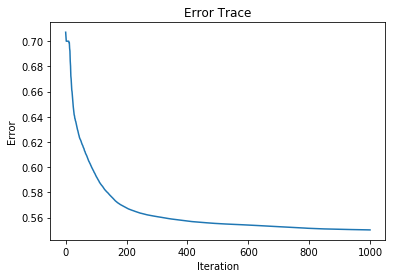

In [31]:
plt.plot(testNN.getErrorTrace())
plt.title("Error Trace")
plt.ylabel("Error")
plt.xlabel("Iteration")

## Testing structures
Here we try some interesting and large neural net structures. I broke it into two stages because of how long they take. I tried to get a wide variety of structures too. The first run found just 100 to be the best, implying that the sheer number of hidden units is favored. [20,20] also did quite well. Running this many can create overtraining however. 

In [32]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, [1,1,1,1,1,1], [5, 5, 5], [20, 20], [10, 10, 10, 10], 
                                           [30,10,30], [50] ,[100]], 10, 400)

In [33]:
summarize(results)

[[0, 67.2784758655117, 66.72254968887975, 0.8924415111541748],
 [[1, 1, 1, 1, 1, 1],
  70.87688619082823,
  70.77029312478206,
  25.440524101257324],
 [[5, 5, 5], 63.44031676456996, 64.90385726916563, 47.040874004364014],
 [[20, 20], 52.96607292774039, 61.044273281145614, 80.90078997612],
 [[10, 10, 10, 10], 57.436213359323844, 62.179447936106044, 77.40060591697693],
 [[30, 10, 30], 46.950603707997644, 60.67358953220785, 154.5801510810852],
 [[50], 55.80233768531046, 60.87994877796645, 138.92990112304688],
 [[100], 53.052203279394085, 58.515316208538664, 274.1880302429199]]

I followed up on the previous structures to see whether more hidden layers  or hidden units is effective. The first two structures have the same number of units but with different layering. The difference between these can show whether breaking into layers is helpful for the neural network to pick up trends. Then I double the amount of units for the last structure, to see how much performance comes from brute force. 400 seems to be taking an absurd amount of time. I probably will not use that again if I can avoid it. 

In [34]:
resultsPlus = trainNNs(Xenergy, Tenergy, 0.8, [0, [20, 20, 20, 20], 
                                                [50,50,50,50], [200]], 10, 400)

In [35]:
summarize(resultsPlus)

[[0, 67.32539844603072, 66.53211251512673, 0.8006851673126221],
 [[20, 20, 20, 20], 48.317501610713215, 60.85903122408803, 133.76309251785278],
 [[50, 50, 50, 50], 41.28587221883414, 55.87739687972571, 531.0524685382843],
 [[200], 51.61995256181012, 56.18616763344435, 552.6569983959198]]

Training the best neural network and analyzing the results.

In [36]:
print(bestNetwork(summarize(results)))
print(bestNetwork(summarize(resultsPlus)))

[[100], 53.052203279394085, 58.515316208538664, 274.1880302429199]
[[50, 50, 50, 50], 41.28587221883414, 55.87739687972571, 531.0524685382843]


In [37]:
bestNN = nn.NeuralNetwork(Xenergy.shape[1], [50,50,50,50], Tenergy.shape[1])
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xenergy, Tenergy, (.8, .2), False)
bestNN.train(Xtrain, Ytrain, 400) #300 should be fine

NeuralNetwork(24, [50, 50, 50, 50], 2)
   Network was trained for 401 iterations. Final error is 0.37246671042246715.

Here we will test the neural network by comparing its predicted results to the actual results. 

In [38]:
Ypredicted = bestNN.use(Xenergy)

Text(0.5,0,'Actual')

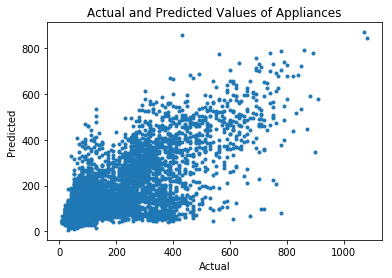

In [39]:
plt.plot(Tenergy[:,0], Ypredicted[:,0], ".")
plt.title("Actual and Predicted Values of Appliances")
plt.ylabel("Predicted")
plt.xlabel("Actual")

This graph shows the actual vs predicted value of appliance using the "best" neural network. There at least appears to be a postive trend, but it is not a clean predictive graph. One of the biggest trends is that the network does not ever predict high values. The actual data has outputs all the way up to 1000, but because so many of the outputs are much lower, the neural network has not learned to output values that high frequently. 

Text(0.5,0,'Actual')

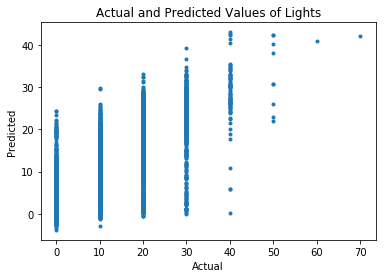

In [40]:
plt.plot(Tenergy[:,1], Ypredicted[:,1], ".")
plt.title("Actual and Predicted Values of Lights")
plt.ylabel("Predicted")
plt.xlabel("Actual")

This compares the lights data with the same predicted vs actual structure. This shows an interesting trend about the lights data. Only the values [0,20,30,40,50,60,70] appear in the dataset, but the neural network outputs data all over the place, and never abouve 30. Because of this binning of lights, its possible a classification could work better. 

Here we will take a close look at the graph above by expanding one of the vertical stripes.

Text(0.5,0,'Observation')

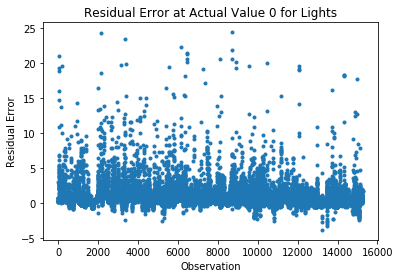

In [41]:
zeroIndices = np.where(Tenergy[:,1] == 0)
zeroIndices
vals = Ypredicted[zeroIndices,1]
plt.plot(vals.transpose(), ".")
plt.title("Residual Error at Actual Value 0 for Lights")
plt.ylabel("Residual Error")
plt.xlabel("Observation")

Here is a plot of the actual vs predicted at only the actual values of zero. This gives a better visual than the graph above by not collapsing all of the observations onto one axis. According to this graph, the neural network seems to actually be doing a good jop of predicting near zero when the input results in zero. 

Text(0.5,0,'Observation')

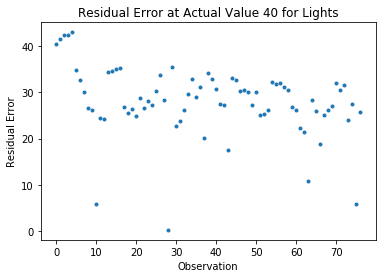

In [42]:
fortyIndices = np.where(Tenergy[:,1] == 40)
fortyIndices
vals = Ypredicted[fortyIndices,1]
plt.plot(vals.transpose(), ".")
plt.title("Residual Error at Actual Value 40 for Lights")
plt.ylabel("Residual Error")
plt.xlabel("Observation")

When we pick a higher traget though, the picture is not nearly as good. The neural network does not seem to have any pattern to its predictions when the result should be forty. Although much of this is because there are simply not many samples that have this target value.

Here are some plots of residuals! I encluded these just to see if any clear trends could be found even though they are not required. 

Text(0.5,0,'Observation')

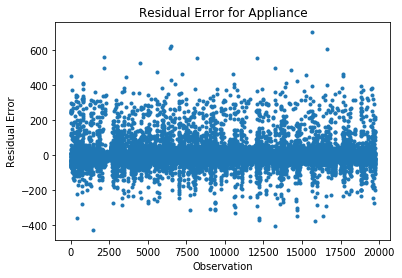

In [43]:
plt.plot(Tenergy[:,0] - Ypredicted[:,0], ".")
plt.title("Residual Error for Appliance")
plt.ylabel("Residual Error")
plt.xlabel("Observation")

This does not look so bad, especially compared to the plot of predicted vs actual. There is a definite positive bias in the residuals that could indicate some consistent errors in the model. There is also some striping issues. This could be something in the data that throws off the model, like a certain variable that tends to make it predict wrongly. 

Text(0.5,0,'Observation')

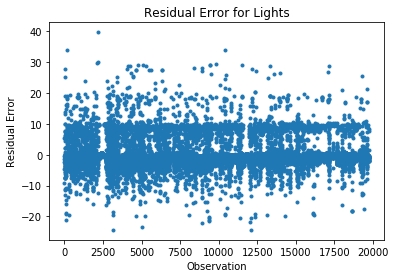

In [44]:
plt.plot(Tenergy[:,1] - Ypredicted[:,1], ".")
plt.title("Residual Error for Lights")
plt.ylabel("Residual Error")
plt.xlabel("Observation")

This residual plot for lights is really interesting. You can see the horizontal stripes of consitent error. These move in ten step increments, showing that the model is sort of misclassifying the data. 

This section tests out a regular old regression model.

In [45]:
mod = linearRegression(Xenergy, Tenergy)

In [46]:
mod
#adds a column of ones for intercept.
XenergyPrime = np.c_[np.ones(len(Xenergy)), Xenergy] 
linearPrediction = XenergyPrime @ mod[1]

Graph of predicted and actual with a simple linear regression.

Text(0,0.5,'Predicted Appliance')

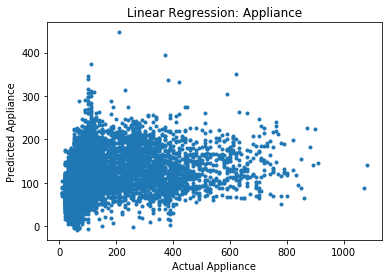

In [47]:
plt.plot(Tenergy[:,0], linearPrediction[:,0], ".")
plt.title("Linear Regression: Appliance")
plt.xlabel("Actual Appliance")
plt.ylabel("Predicted Appliance")

A regular linear regression actually performs just as well as other simple neural network structures. The complex structure above may have some overtraining going on. 

Text(0,0.5,'Predicted Lights')

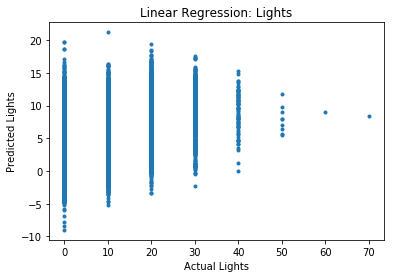

In [48]:
plt.plot(Tenergy[:,1], linearPrediction[:,1], ".")
plt.title("Linear Regression: Lights")
plt.xlabel("Actual Lights")
plt.ylabel("Predicted Lights")

The linear regression does not do a great job on lights however. A different strategy should probably be used given the nature of the target variables.

Text(0.5,0,'Observation')

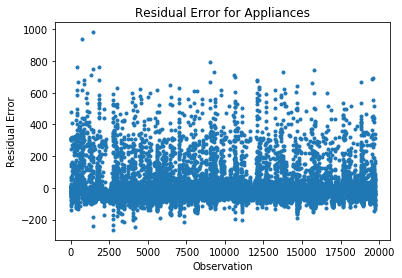

In [49]:
plt.plot(Tenergy[:,0] - linearPrediction[:,0], ".")
plt.title("Residual Error for Appliances")
plt.ylabel("Residual Error")
plt.xlabel("Observation")

The residual plot of the linear regression for appliances looks similar to the one produced by the neural network. It helps to show that the positive bias of the residuals was not due to something wrong with the network, but rather a bias and non-normality in the data. 

Text(0.5,0,'Observation')

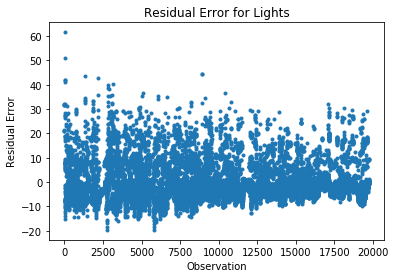

In [50]:
plt.plot(Tenergy[:,1] - linearPrediction[:,1], ".")
plt.title("Residual Error for Lights")
plt.ylabel("Residual Error")
plt.xlabel("Observation")

Here we see a different picture than the residuals created by the neural network when predicting for lights. The striping does not really appear here, probably because the simple linear regression can not pick up on the binned nature of the data while the neural network does. 

# Running Classication on the Frog Dataset
This section reads in the Anuran calls csv and makes it into a suitable format. Then it runs and interprets a classification.


## Reading in the Data

First read in the csv using pandas again and drop the unneeded columns. `MFCCs_ 1` is not mentioned in the assingment notebook, but I found its value to alway be one and that it was not in the reference output, so I have dropped it along with `RecordID`, `Family`, and `Genus`.

In [51]:
csv = pd.read_csv("Frogs_MFCCs.csv")
csv = csv.drop(['RecordID', 'Family', 'Genus', 'MFCCs_ 1'], axis = 1) #also drops MFCCs_1, 
                                                                    #which only has the value 1, no in his.

In [52]:
csv.shape

(7195, 22)

Here we convert the pandas data frame into a numpy matrix. It is mostly striaghtforward like the regression data, except for the typing. For some reason, pandas read the call data as python floats, which cannot be used like numpy floats. This caused me a giant headache and threw all sorts of weird errors later on. Eventually I worked my way back here and realized I needed to change the matrix to use numpy.float64 instead of python float.

In [53]:
data = csv.values
Tanuran = data[:, 21:]
Xanuran = data[:, :21]
Xanuran = Xanuran.astype(np.float64)
#print(type(Xanuran[1,1]))
#print(Xanuran.astype(np.float64))
#print(type(Xenergy[1,1]))

Here we check in on the expected shape. We ought to have 7195x21 and 7195x1 for `Xanuran` and `Tanuran` respectively.

In [54]:
Xanuran.shape, Tanuran.shape

((7195, 21), (7195, 1))

A few samples to compare to reference. Without dropping `MFCCs_ 1`, each entry would start with 1.0.

In [55]:
Xanuran[:2,:]

array([[ 0.1529363 , -0.1055859 ,  0.20072191,  0.31720106,  0.26076385,
         0.10094464, -0.1500626 , -0.17112763,  0.12467644,  0.18865415,
        -0.07562172, -0.15643593,  0.08224512,  0.13575204, -0.02401665,
        -0.10835111, -0.07762252, -0.0095678 ,  0.05768398,  0.11868014,
         0.01403845],
       [ 0.17153426, -0.09897474,  0.26842522,  0.33867186,  0.2683531 ,
         0.06083509, -0.22247464, -0.20769267,  0.17088287,  0.27095828,
        -0.09500394, -0.25434147,  0.02278623,  0.1633201 ,  0.01202228,
        -0.09097401, -0.05650952, -0.03530336,  0.02013996,  0.08226299,
         0.02905574]])

Here we change each species name to an int representing its classification. This is done by finding the unique species names, and then changing each entry from its species name to the index of the entry of the species name in the name list. 

In [56]:
names = np.unique(Tanuran)
names = list(names)
for i in range(len(Tanuran)):
    Tanuran[i] = names.index(Tanuran[i])
#Tanuran = [names.index(n) for n in Tanuran]
#Tanuran = [[x] for x in Tanuran]
#Tanuran = np.array(Tanuran)

We expect the `Xanuran` matrix to have 21 columns.

In [57]:
Xanuran.shape[1]

21

In [58]:
Tanuran = Tanuran.astype(np.int)
Tanuran[:2]

array([[0],
       [0]])

Verify that our classification has been done correctly. There is some variance in the number of samples in each class, so we should expect the effectiveness in classifying each to be variable.

In [59]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


A sanity check of whether classify works and gets reasonable outputs.

In [60]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 10, 100, classify=True)

In [61]:
summarize(results)

[[0, 2.6094510076441972, 3.6136205698401676, 2.262219190597534],
 [5, 3.417303683113274, 4.308547602501736, 4.1121580600738525],
 [[5, 5], 9.555246699096596, 10.264072272411397, 5.083386659622192]]

In [62]:
bestNetwork(summarize(results))

[0, 2.6094510076441972, 3.6136205698401676, 2.262219190597534]

## Finding a  reasonable number of iterations
Follow the same logic as last time. We run on the most complex of the preliminary structures above to see if it is getting enough time to learn. 

Text(0.5,0,'Iteration')

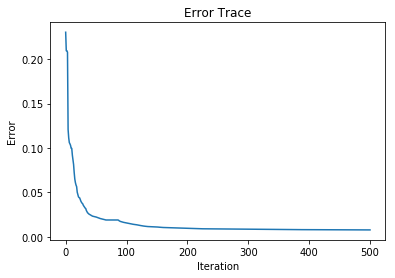

In [63]:
#Create and train the nn.
#Do this with 1000, but maybe on your desktop.
testNN = nn.NeuralNetworkClassifier(Xanuran.shape[1], [5,5], len(np.unique(Tanuran)))
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xanuran, Tanuran, (.8, .2), False)
testNN.train(Xtrain, Ytrain, 500) #300 should be fine
#Final error is not the same as RMSE
plt.plot(testNN.getErrorTrace())
plt.title("Error Trace")
plt.ylabel("Error")
plt.xlabel("Iteration")

Following this trial, 250 should give enough iterations. More complex models may need more time to learn the model, but without GPU acceleration I will not have the time!

## Testing Structures
Like last time, testing will be broken up. This makes it more reasonable to rerun some of the tests from a time standpoint. This will contain some really odd structures just to see how they behave, as well as some more reasonable ones. 

In [64]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0,[1], [1,1,2,3,5,8,13,21], [20,10,5, 5,10, 20], [100]], 5, 250, classify=True)

In [65]:
summarize(results)

[[0, 2.8874218207088265, 3.5024322446143152, 2.580542802810669],
 [[1], 25.472550382209867, 26.60180681028492, 3.437645673751831],
 [[1, 1, 2, 3, 5, 8, 13, 21],
  29.44058373870743,
  30.00694927032662,
  16.488845586776733],
 [[20, 10, 5, 5, 10, 20],
  1.9214732453092425,
  4.141765114662959,
  16.98670721054077],
 [[100], 0.0, 1.0840861709520477, 22.063396215438843]]

Looks like the fibbonacci network is not very effective. The second structure is not too bad, works better than a regression. The big network worked very well on the training data, but also worked well on the test data. With that many hidden units, it could be that the neural network is learning every training input.

In [66]:
resultsTwo = trainNNs(Xanuran, Tanuran, 0.8, [200, [50, 2, 50], [2]*20], 5, 250, classify=True)

In [67]:
summarize(resultsTwo)

[[200, 0.0, 1.1813759555246706, 40.353668212890625],
 [[50, 2, 50], 0.3127171646977067, 3.64141765114663, 21.29509711265564],
 [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  51.53231410701876,
  52.17512161223071,
  3.057204246520996]]

Here I tried another odd structure to see how it would behave. Looks like a whole bunch of layers with few units does not do a good job of classifying. The 200 hidden unit structure continued to improve upon the last large structure, although continuing to add units may not work well. Also interesting to see was the [50,2,50] structure, which still classified well even with the chokepoint. 

In [68]:
resultsThree = trainNNs(Xanuran, Tanuran, 0.8, [[10,10], [5, 5, 5]], 5, 250, classify=True)

In [69]:
summarize(resultsThree)

[[[10, 10], 0.03822098679638675, 2.9742876997915224, 7.625989675521851],
 [[5, 5, 5], 2.894371091035441, 4.100069492703264, 6.957341432571411]]

In [70]:
bestNetwork(summarize(results)),bestNetwork(summarize(resultsTwo)),bestNetwork(summarize(resultsThree))

([[100], 0.0, 1.0840861709520477, 22.063396215438843],
 [200, 0.0, 1.1813759555246706, 40.353668212890625],
 [[10, 10], 0.03822098679638675, 2.9742876997915224, 7.625989675521851])

Of all of the network structures tested, the 100 hidden unit performed the best on testing data. This has a high change of over fitting the model however, and it may be better to use a simpler model to be able to more easily interpret the data. A simple network without any hidden units classifies correctly 3.79% of the time on test data, so it may be worth choosing for its simplicity over difficult to interpret hidden units. For analyses, I will look at the both the [10,10] network and the 100 network to compare them.

In [71]:
simpleNN = nn.NeuralNetworkClassifier(Xanuran.shape[1], [10,10], len(np.unique(Tanuran)))
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xanuran, Tanuran, (.8, .2), False)
simpleNN.train(Xtrain, Ytrain, 250) 

bestNN = nn.NeuralNetworkClassifier(Xanuran.shape[1], [100], len(np.unique(Tanuran)))
Xtrain,Ytrain,Xtest,Ytest=ml.partition(Xanuran, Tanuran, (.8, .2), False)
bestNN.train(Xtrain, Ytrain, 250)

NeuralNetwork(21, [100], 10)
   Network was trained for 250 iterations. Final error is 2.5842343714332944e-07.

We see that the error is low, so the network is well trained. We will continue by looking at the amount of correctly classified frogs.

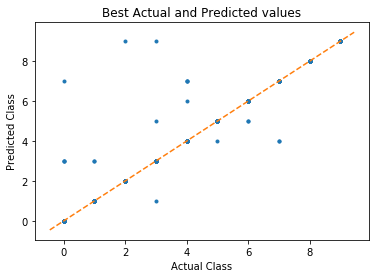

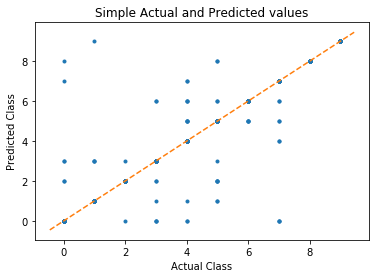

In [72]:
bPredictedClass = bestNN.use(Xanuran)
plt.plot(bPredictedClass, Tanuran, ".")
plt.title("Best Actual and Predicted values")
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
abline(1,0)
plt.show()
sPredictedClass = simpleNN.use(Xanuran)
plt.plot(sPredictedClass, Tanuran, ".")
plt.title("Simple Actual and Predicted values")
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
abline(1,0)

Thats a pretty good looking line! Datapoints that lie on the line represent a correctly classified frog by its calls. The points above a line are misclassification errors. The handful of errors should not really be a concern, given the size of the dataset we have. We see here that the best network has fewer errors, but the simple network certainly does not slack either showing a strong classification ability.

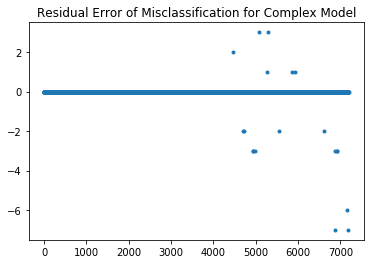

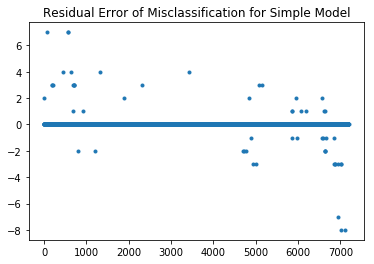

In [73]:
plt.plot(bPredictedClass - Tanuran, ".")
plt.title("Residual Error of Misclassification for Complex Model")
plt.show()
plt.plot(sPredictedClass - Tanuran, ".")
plt.title("Residual Error of Misclassification for Simple Model")
plt.show()


Here we can see both the simple and complex network perform very well. As is expected, the simple model has some more misclassifications, but not drastically more. If this was a linear regression, we might wory about the pattern in the residuals, but this trend makes sense for classification. If the correct class is 9 and 9 happens to be the highest class, only errors negative errors will occur. Because of this there are more positive errors for low classifications and more negative erros for high classifications. 

When comparing these two it is clear that the 200 hidden unit network performs better. However, they show very similar trends in their residual and predicted vs actual value plots. Considering the additional complexity of the 200 unit network, not to mention the time difference (41 vs 7 seconds), the simple [10,10] network may be a better choice. Because this model is more simple, it may more flexible and applicable to future datasets. 